# Sequence Models I
## 4.1 

### Assignment Solution - Classify Musical Instruments

In [1]:
!pip install tensorflow==2.0.0-beta0

  Using cached https://files.pythonhosted.org/packages/6c/19/0d0c7f240db7bcd6b83783b9a89a67f38584d100e23ad5ae93114be92232/tensorflow-2.0.0b0-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/a4/96/571b875cd81dda9d5dfa1422a4f9d749e67c0a8d4f4f0b33a4e5f5f35e27/tb_nightly-1.14.0a20190603-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/32/dd/99c47dd007dcf10d63fd895611b063732646f23059c618a373e85019eb0e/tf_estimator_nightly-1.14.0.dev2019060501-py2.py3-none-any.whl
  Found existing installation: tb-nightly 1.14.0a20190301
    Uninstalling tb-nightly-1.14.0a20190301:
      Successfully uninstalled tb-nightly-1.14.0a20190301
  Found existing installation: tf-estimator-nightly 1.14.0.dev2019030115
    Uninstalling tf-estimator-nightly-1.14.0.dev2019030115:
      Successfully uninstalled tf-estimator-nightly-1.14.0.dev2019030115
  Found existing installation: tensorflow 2.0.0a0
    Uninstalling tensorflow-2.0.0a0:
      Successfully un

In [0]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
LIST_OF_LABELS = "piano,guitar,drums".split(',')
HEIGHT = 300
WIDTH = 300
NUM_CHANNELS = 3
NCLASSES = len(LIST_OF_LABELS)
BATCH_SIZE = 32

In [0]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
piano_df = pd.read_csv('/content/gdrive/My Drive/instruments/piano.csv')
guitar_df = pd.read_csv('/content/gdrive/My Drive/instruments/guitar.csv')
drums_df = pd.read_csv('/content/gdrive/My Drive/instruments/drums.csv')

In [7]:
piano_df.head()

,url,reference
0,http://www.davemurphyband.com/gallery/11850889...,n03273551_5755
1,http://farm1.static.flickr.com/160/420012905_c...,n03273551_5894
2,http://farm3.static.flickr.com/2131/2115062910...,n03273551_7076
3,http://upload.wikimedia.org/wikipedia/commons/...,n03273551_14037
4,http://lh5.ggpht.com/_RjEKbo0OXP4/SE97o4gC5PI/...,n03273551_15410


In [8]:
piano_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1261 entries, 0 to 1260
Data columns (total 2 columns):
url          1261 non-null object
reference    1261 non-null object
dtypes: object(2)
memory usage: 19.8+ KB


In [9]:
print(piano_df.loc[0,'url'])

http://www.davemurphyband.com/gallery/1185088993_1.jpg


### download files
#### I am fetching only 100, but you should fetch all by using piano_df.shape[0]

In [0]:
files, categories = [],[] # let's keep track of file names and their categories

In [11]:
for i in range(10):
  try:
    tf.keras.utils.get_file(fname='{}.jpg'.format(i), origin=piano_df.loc[i, 'url'], extract=True, cache_subdir='/content/files/piano'.format(i))
    files.append('/content/files/piano/{}.jpg'.format(i))
    categories.append(0)
  except:
    continue

In [12]:
!ls files/piano/*

files/piano/0.jpg   files/piano/3.jpg	files/piano/64.jpg  files/piano/84.jpg
files/piano/11.jpg  files/piano/40.jpg	files/piano/65.jpg  files/piano/85.jpg
files/piano/12.jpg  files/piano/41.jpg	files/piano/70.jpg  files/piano/86.jpg
files/piano/13.jpg  files/piano/43.jpg	files/piano/71.jpg  files/piano/87.jpg
files/piano/19.jpg  files/piano/44.jpg	files/piano/72.jpg  files/piano/88.jpg
files/piano/1.jpg   files/piano/46.jpg	files/piano/73.jpg  files/piano/91.jpg
files/piano/20.jpg  files/piano/49.jpg	files/piano/74.jpg  files/piano/93.jpg
files/piano/21.jpg  files/piano/4.jpg	files/piano/75.jpg  files/piano/95.jpg
files/piano/24.jpg  files/piano/51.jpg	files/piano/77.jpg  files/piano/97.jpg
files/piano/2.jpg   files/piano/55.jpg	files/piano/79.jpg  files/piano/98.jpg
files/piano/30.jpg  files/piano/56.jpg	files/piano/7.jpg   files/piano/99.jpg
files/piano/32.jpg  files/piano/58.jpg	files/piano/80.jpg  files/piano/9.jpg
files/piano/34.jpg  files/piano/61.jpg	files/piano/81.jpg
files/pia

In [13]:
for i in range(10):
  try:
    tf.keras.utils.get_file(fname='{}.jpg'.format(i), origin=guitar_df.loc[i, 'url'], extract=True, cache_subdir='/content/files/guitar'.format(i))
    files.append('/content/files/guitar/{}.jpg'.format(i))
    categories.append(1)
  except:
    continue

In [14]:
for i in range(10):
  try:
    tf.keras.utils.get_file(fname='{}.jpg'.format(i), origin=drums_df.loc[i, 'url'], extract=True, cache_subdir='/content/files/drums'.format(i))
    files.append('/content/files/drums/{}.jpg'.format(i))
    categories.append(2)
  except:
    continue

In [15]:
!ls files

drums  guitar  piano


### convert lists into a Pandas DataFrame

In [16]:
train_file_df = pd.DataFrame({'filename': files, 'class': categories})
train_file_df.head()

,filename,class
0,/content/files/piano/0.jpg,0
1,/content/files/piano/1.jpg,0
2,/content/files/piano/2.jpg,0
3,/content/files/piano/3.jpg,0
4,/content/files/piano/4.jpg,0


### Try to read a file

In [0]:
def preprocess_image(image):
  image = tf.image.decode_image(contents=image, channels=NUM_CHANNELS, expand_animations=False)
  image = tf.image.resize(image, [HEIGHT, WIDTH])
  image /= 255.0  # normalize to [0,1] range

  return image

def load_and_preprocess_image(path):
  image = tf.io.read_file(path)
  return preprocess_image(image)

In [23]:
filename = files[1]
img = tf.io.read_file(files[1])
#img = tf.image.decode_image(contents=img, channels=NUM_CHANNELS, expand_animations=False)
img = preprocess_image(img)
print(img)

tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(300, 300, 3), dtype=float32)


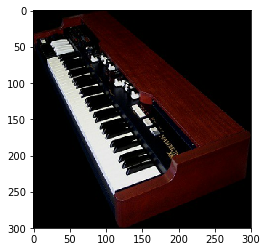

In [24]:
plt.imshow(img)

### Image preprocessing functions and operations

In [25]:
print(files[1])

/content/files/piano/1.jpg


In [26]:
path_ds = tf.data.Dataset.from_tensor_slices(files)
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
image_ds

<ParallelMapDataset shapes: (300, 300, None), types: tf.float32>

In [27]:
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(categories, tf.int64))
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))
image_label_ds

<ZipDataset shapes: ((300, 300, None), ()), types: (tf.float32, tf.int64)>

In [28]:
ds = image_label_ds.shuffle(buffer_size=1000 * BATCH_SIZE)
ds = ds.repeat()
ds = ds.batch(BATCH_SIZE)
# `prefetch` lets the dataset fetch batches, in the background while the model is training.
ds = ds.prefetch(buffer_size=AUTOTUNE)
ds

<PrefetchDataset shapes: ((None, 300, 300, None), (None,)), types: (tf.float32, tf.int64)>

### create a model

In [29]:
model = models.Sequential([
    layers.Conv2D(filters=96, kernel_size=(11, 11), strides=4, activation='relu', input_shape=(HEIGHT, WIDTH, NUM_CHANNELS), bias_initializer=tf.initializers.zeros(), kernel_initializer=tf.initializers.RandomNormal(mean=0, stddev=0.01)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(filters=256, kernel_size=(5, 5), activation='relu', bias_initializer=tf.initializers.ones(), kernel_initializer=tf.initializers.RandomNormal(mean=0, stddev=0.01)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(filters=384, kernel_size=(3, 3), activation='relu', bias_initializer=tf.initializers.zeros(), kernel_initializer=tf.initializers.RandomNormal(mean=0, stddev=0.01)),
    layers.Conv2D(filters=384, kernel_size=(3, 3), activation='relu', bias_initializer=tf.initializers.ones(), kernel_initializer=tf.initializers.RandomNormal(mean=0, stddev=0.01)),
    layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', bias_initializer=tf.initializers.ones(), kernel_initializer=tf.initializers.RandomNormal(mean=0, stddev=0.01)),
    layers.MaxPooling2D(),
    layers.Dense(4096, activation='relu', bias_initializer=tf.initializers.ones(), kernel_initializer=tf.initializers.RandomNormal(mean=0, stddev=0.01)),
    layers.Dropout(0.5),
    layers.Dense(4096, activation='relu', bias_initializer=tf.initializers.ones(), kernel_initializer=tf.initializers.RandomNormal(mean=0, stddev=0.01)),
    layers.Dropout(0.5),
    layers.Dense(4096, activation='relu', kernel_initializer=tf.initializers.RandomNormal(mean=0, stddev=0.01)),
    layers.Dense(NCLASSES, activation='softmax', bias_initializer=tf.initializers.ones())
])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 73, 73, 96)        34944     
_________________________________________________________________
batch_normalization (BatchNo (None, 73, 73, 96)        384       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 36, 36, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 256)       614656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 256)       1024      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 384)       8

In [0]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, decay=0.0005)

In [0]:
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#### You should change the number of epochs and steps_per_epoch to numbers that help you converge.

In [0]:
model.fit(ds, epochs=1, steps_per_epoch=2)